<h1>Forecasting Innovational Outliers using Autenecoder-LSTM in Time Series</h1>

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import datetime as dt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter

import warnings
warnings.filterwarnings('ignore')
sns.set_theme()

## Load and processing data

In [37]:
df = pd.read_csv('../data/small_data.csv', usecols=['time', 'temp_ice', 'temp_inside', 'temp_outside'])
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,temp_ice,temp_inside,temp_outside
0,2022-09-27 10:11:00,-4.558333,7.940385,6.387500
1,2022-09-27 10:12:00,-4.485500,7.948077,6.446833
2,2022-09-27 10:13:00,-4.356587,7.937500,6.506166
3,2022-09-27 10:14:00,-4.438758,7.950000,6.565500
4,2022-09-27 10:15:00,-4.393290,7.900000,6.624833


In [38]:
# detect resurfacing
df = (df
 # Handling anomalous values 
 .assign(temp_ice=lambda df: df['temp_ice'].clip(lower=-10, upper=3))
 .assign(temp_ice=lambda df: df['temp_ice'].ffill())
 # Differentialize the exponentially smoothed series to find the resurfacing 
 .assign(diff=lambda df: df['temp_ice'].ewm(span=60).mean().diff())
 .assign(resurfacing=lambda df: np.where(df['diff'] > 0.03, 1, 0))
 # Create a trait to calculate the time between resurfacing
 .assign(diff_time=dt.timedelta(minutes=30))
 )

# Counting the correct number of resurfacing
df.loc[df['resurfacing'] == 1, 'diff_time'] = df.loc[df['resurfacing'] == 1, 'time'].diff().fillna(dt.timedelta(minutes=30))
df.loc[df['diff_time'] < dt.timedelta(minutes=30), 'resurfacing'] = 0
df = df.drop(columns=['diff', 'diff_time'])

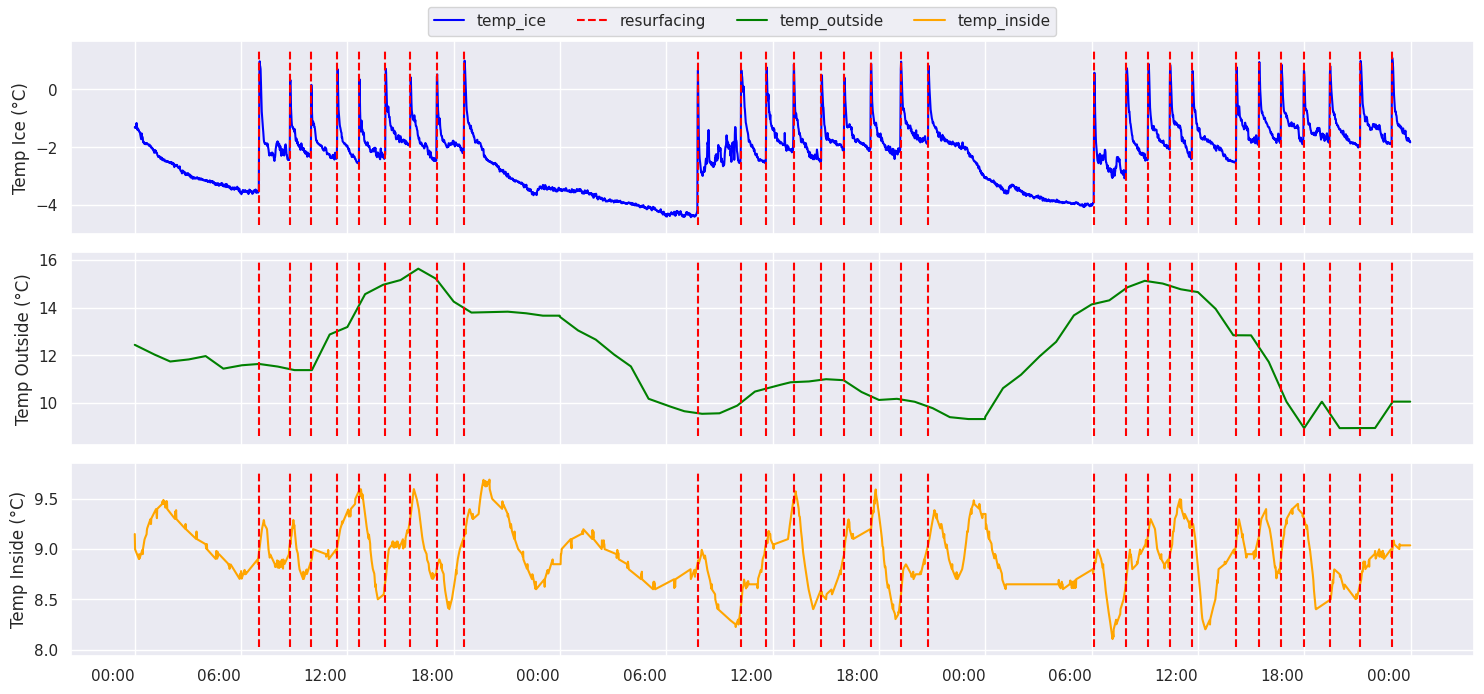

In [14]:
# Sampling the data for the desired time period
df_sample = df.set_index('time').loc['2022-10-01':'2022-10-03']

# Create the figure and axes for the subgraphs
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 7), sharex=True)

# Temperature signatures on individual subplots
axes[0].plot(df_sample.index, df_sample['temp_ice'], label='temp_ice', color='blue')
axes[0].set_ylabel('Temp Ice (°C)')

axes[1].plot(df_sample.index, df_sample['temp_outside'], label='temp_outside', color='green')
axes[1].set_ylabel('Temp Outside (°C)')

axes[2].plot(df_sample.index, df_sample['temp_inside'], label='temp_inside', color='orange')
axes[2].set_ylabel('Temp Inside (°C)')

# Add vertical lines for resurfacing
for ax in axes:
    ax.vlines(df_sample[df_sample['resurfacing'] == 1].index, 
              ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], 
              color='red', linestyle='--', label='resurfacing')

# Create a common legend for all charts
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
fig.legend(handles, labels, loc='upper center', ncol=6)

# Formatting the time axis (x-axis)
locator = mdates.AutoDateLocator(minticks=5, maxticks=20)  # Automatic selection of timestamps
formatter = mdates.DateFormatter('%H:%M')  # Format timestamps without seconds
axes[2].xaxis.set_major_locator(locator)
axes[2].xaxis.set_major_formatter(formatter)

# Rotate the x-axis labels for better readability
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=0, ha='right')

# Set compact layout of subgraphs
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the overall legend
plt.show()


In [39]:
# sin and cos component features
df['min_sin'] = np.sin(2 * np.pi * df['time'].dt.minute / 60)
df['min_cos'] = np.cos(2 * np.pi * df['time'].dt.minute / 60)
df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['time'].dt.day_of_week / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['time'].dt.day_of_week / 7)

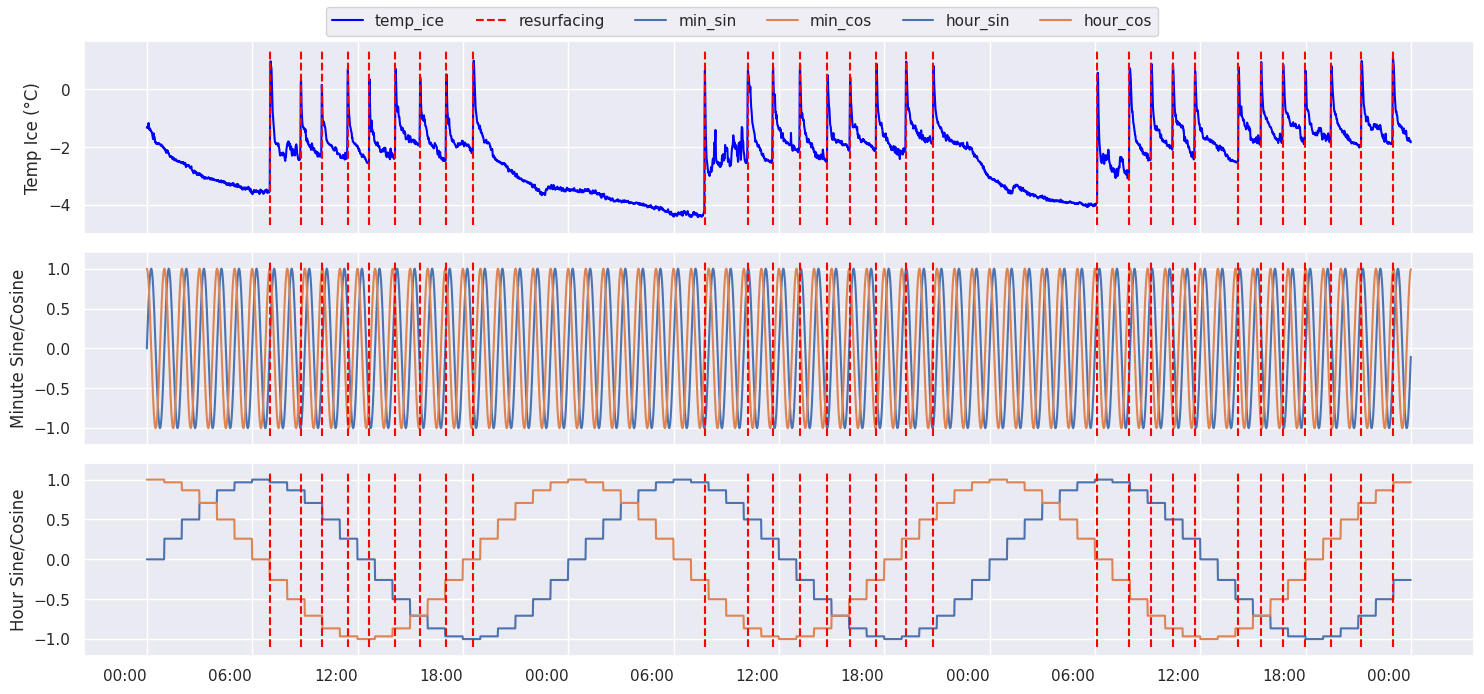

In [85]:
# Create the figure and axes for the subgraphs
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 7), sharex=True)

# Temperature signatures on individual subplots
axes[0].plot(df_sample.index, df_sample['temp_ice'], label='temp_ice', color='blue')
axes[0].set_ylabel('Temp Ice (°C)')

axes[1].plot(df_sample.index, df_sample['min_sin'], label='min_sin')
axes[1].plot(df_sample.index, df_sample['min_cos'], label='min_cos')
axes[1].set_ylabel('Minute Sine/Cosine')

axes[2].plot(df_sample.index, df_sample['hour_sin'], label='hour_sin')
axes[2].plot(df_sample.index, df_sample['hour_cos'], label='hour_cos')
axes[2].set_ylabel('Hour Sine/Cosine')

# Add vertical lines for resurfacing
for ax in axes:
    ax.vlines(df_sample[df_sample['resurfacing'] == 1].index, 
              ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], 
              color='red', linestyle='--', label='resurfacing')

# Create a common legend for all charts
handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)
fig.legend(handles, labels, loc='upper center', ncol=6)

# Formatting the time axis (x-axis)
locator = mdates.AutoDateLocator(minticks=5, maxticks=20)  # Automatic selection of timestamps
formatter = mdates.DateFormatter('%H:%M')  # Format timestamps without seconds
axes[2].xaxis.set_major_locator(locator)
axes[2].xaxis.set_major_formatter(formatter)

# Rotate the x-axis labels for better readability
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=0, ha='right')

# Set compact layout of subgraphs
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the overall legend
plt.show()


## Classical ML

In [40]:
# Function to create rolling statistical features
def create_features(data, window_size=120):
    data = data.copy()
    # Rolling window features
    rolling_features = data[['temp_ice', 'temp_inside', 'temp_outside']].rolling(window=window_size, min_periods=1)
    data['temp_ice_mean'] = rolling_features['temp_ice'].mean()
    data['temp_ice_std'] = rolling_features['temp_ice'].std()
    data['temp_inside_mean'] = rolling_features['temp_inside'].mean()
    data['temp_inside_std'] = rolling_features['temp_inside'].std()
    data['temp_outside_mean'] = rolling_features['temp_outside'].mean()
    data['temp_outside_std'] = rolling_features['temp_outside'].std()
    # Fill NaN values resulting from std calculation
    data.fillna(method='bfill', inplace=True)
    return data


# Create a copy of the dataframe to avoid modifying the original data
df_window = df.copy()

# Apply feature creation
df_window = create_features(df_window, window_size=120)

# Drop initial rows without enough history
df_window = df_window.iloc[119:].reset_index(drop=True)

# Prepare feature matrix X and target vector y
feature_cols = [
    'temp_ice_mean', 'temp_ice_std',
    'temp_inside_mean', 'temp_inside_std',
    'temp_outside_mean', 'temp_outside_std',
    'min_sin', 'min_cos',
    'hour_sin', 'hour_cos',
    'dow_sin', 'dow_cos'
]


# Initialize the new target variable with zeros
df_window['resurfacing_window'] = 0

# Get indices where resurfacing events occur
resurfacing_indices = df_window.index[df_window['resurfacing'] == 1].tolist()

# For each resurfacing event, set the target variable to 1 for ±5 minutes
window_size = 5  # 5 minutes before and after
for idx in resurfacing_indices:
    start_idx = max(idx - window_size, 0)
    end_idx = min(idx + window_size + 1, len(df_window))
    df_window.loc[start_idx:end_idx, 'resurfacing_window'] = 1

# Shift the target variable to predict 30 minutes ahead
df_window['resurfacing_future'] = df_window['resurfacing_window'].shift(-30)
# Drop rows with NaN in the target variable
df_window.dropna(subset=['resurfacing_future'], inplace=True)

# Prepare feature matrix X and target vector y
X = df_window[feature_cols]
y = df_window['resurfacing_future']

# X = df[feature_cols]
# y = df['resurfacing']

In [41]:
# Shift target variable to predict 30 minutes ahead (30 steps)
y = y.shift(-30)
df_window['resurfacing_future'] = y
# Drop the last 30 rows with NaN targets
df_window = df_window.iloc[:-30]
X = df_window[feature_cols]
y = df_window['resurfacing_future']

# Split data into training and testing sets preserving temporal order
train_size = int(len(X) * 0.7)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [42]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Support Vector Machine': SVC(probability=True, class_weight='balanced'),
    'XGBoost': XGBClassifier(scale_pos_weight=Counter(y_train)[0] / Counter(y_train)[1], use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(class_weight='balanced', verbose=-1),
    'CatBoost': CatBoostClassifier(verbose=0, train_dir=None, class_weights=[1, Counter(y_train)[0] / Counter(y_train)[1]])
}

In [21]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Create a pipeline with scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    # Fit the model
    pipeline.fit(X_train, y_train)
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)
    
    precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    
    roc_auc = roc_auc_score(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    results = {
        'Model': type(model).__name__,
        'Accuracy': accuracy,
        'Precision (0)': precision_0,
        'Recall (0)': recall_0,
        'F1-Score (0)': f1_0,
        'Precision (1)': precision_1,
        'Recall (1)': recall_1,
        'F1-Score (1)': f1_1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': conf_matrix
    }
    
    return results

metrics_list = []
# Evaluate each model
for name, model in models.items():
    results = evaluate_model(model, X_train, y_train, X_test, y_test)
    metrics_list.append(results)

metrics_df = pd.DataFrame(metrics_list)
metrics_df.round(2)

,Model,Accuracy,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1),ROC AUC,Confusion Matrix
0,LogisticRegression,0.58,0.97,0.57,0.72,0.12,0.77,0.21,0.71,"[[6281, 4802], [203, 661]]"
1,RandomForestClassifier,0.93,0.93,1.00,0.96,1.00,0.00,0.01,0.81,"[[11083, 0], [860, 4]]"
2,SVC,0.80,0.95,0.82,0.88,0.17,0.47,0.25,0.73,"[[9100, 1983], [457, 407]]"
3,XGBClassifier,0.91,0.94,0.97,0.95,0.35,0.22,0.27,0.81,"[[10730, 353], [675, 189]]"
4,LGBMClassifier,0.88,0.95,0.92,0.93,0.26,0.38,0.31,0.82,"[[10160, 923], [533, 331]]"
5,CatBoostClassifier,0.93,0.94,0.99,0.96,0.55,0.22,0.32,0.83,"[[10924, 159], [670, 194]]"


### Handle class imbalance using SMOTE

In [43]:
print(f"Original class distribution: {Counter(y_train)}")

Original class distribution: Counter({0.0: 25510, 1.0: 2364})


In [44]:
# Create a pipeline with SMOTE and the model
def evaluate_model_with_smote(model, X_train, y_train, X_test, y_test):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE()),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)
    
    precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    
    roc_auc = roc_auc_score(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    results = {
        'Model': type(model).__name__,
        'Accuracy': accuracy,
        'Precision (0)': precision_0,
        'Recall (0)': recall_0,
        'F1-Score (0)': f1_0,
        'Precision (1)': precision_1,
        'Recall (1)': recall_1,
        'F1-Score (1)': f1_1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': conf_matrix
    }
    
    return results


metrics_list = []
# Evaluate models with SMOTE
for name, model in models.items():
    results = evaluate_model_with_smote(model, X_train, y_train, X_test, y_test)
    metrics_list.append(results)

smote_metrics_df = pd.DataFrame(metrics_list)
smote_metrics_df.round(2)

,Model,Accuracy,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1),ROC AUC,Confusion Matrix
0,LogisticRegression,0.58,0.97,0.56,0.71,0.12,0.77,0.21,0.71,"[[6231, 4852], [202, 662]]"
1,RandomForestClassifier,0.93,0.93,1.00,0.96,0.68,0.02,0.03,0.81,"[[11077, 6], [851, 13]]"
2,SVC,0.82,0.95,0.85,0.90,0.17,0.40,0.24,0.72,"[[9420, 1663], [518, 346]]"
3,XGBClassifier,0.90,0.94,0.95,0.95,0.29,0.26,0.28,0.77,"[[10528, 555], [636, 228]]"
4,LGBMClassifier,0.93,0.93,1.00,0.96,0.50,0.06,0.11,0.81,"[[11032, 51], [813, 51]]"
5,CatBoostClassifier,0.91,0.95,0.96,0.95,0.37,0.31,0.34,0.81,"[[10622, 461], [594, 270]]"


## Deep learning

In [26]:
df.head()

,time,temp_ice,temp_inside,temp_outside,resurfacing,min_sin,min_cos,hour_sin,hour_cos,dow_sin,dow_cos
0,2022-09-27 10:11:00,-4.558333,7.940385,6.387500,0,0.913545,4.067366e-01,0.5,-0.866025,0.781831,0.62349
1,2022-09-27 10:12:00,-4.485500,7.948077,6.446833,1,0.951057,3.090170e-01,0.5,-0.866025,0.781831,0.62349
2,2022-09-27 10:13:00,-4.356587,7.937500,6.506166,0,0.978148,2.079117e-01,0.5,-0.866025,0.781831,0.62349
3,2022-09-27 10:14:00,-4.438758,7.950000,6.565500,0,0.994522,1.045285e-01,0.5,-0.866025,0.781831,0.62349
4,2022-09-27 10:15:00,-4.393290,7.900000,6.624833,0,1.000000,2.832769e-16,0.5,-0.866025,0.781831,0.62349


In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Simple LSTM

In [45]:
# Сдвиг целевой переменной для прогнозирования 30 минут вперед
sequence_length = 120
prediction_offset = 30

df['resurfacing_future'] = df['resurfacing'].shift(-prediction_offset)
df.dropna(subset=['resurfacing_future'], inplace=True)

# Определение признаков и целевой переменной
feature_cols = [
    'temp_ice', 'temp_inside', 'temp_outside', 
    'min_sin', 'min_cos', 
    'hour_sin', 'hour_cos', 
    'dow_sin', 'dow_cos'
]
X = df[feature_cols]
y = df['resurfacing_future']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки с сохранением временного порядка
train_size = int(len(X_scaled) * 0.7)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:len(y)]

# Создание кастомного класса Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length=120):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length

    def __getitem__(self, idx):
        X_seq = self.X[idx : idx + self.sequence_length]
        y_target = self.y[idx + self.sequence_length]
        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_target, dtype=torch.float32)

# Параметры
batch_size = 64

# Создание Dataset и DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train.values, sequence_length)
test_dataset = TimeSeriesDataset(X_test, y_test.values, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, lstm_hidden_size=64, lstm_layers=2, fc_dim=16, dropout=0.2):
        super(LSTMClassifier, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers

        self.lstm = nn.LSTM(input_dim, lstm_hidden_size, lstm_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_size, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: [batch_size, sequence_length, input_dim]
        h0 = torch.zeros(self.lstm_layers, x.size(0), self.lstm_hidden_size).to(device)
        c0 = torch.zeros(self.lstm_layers, x.size(0), self.lstm_hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))  # out: [batch_size, sequence_length, hidden_size]
        out = out[:, -1, :]  # Последнее временное состояние
        out = self.fc(out)
        return out

In [32]:
def train_lstm(model, dataloader, criterion, optimizer, num_epochs=50, patience=10):
    model.train()
    best_loss = np.inf
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        
        epoch_loss /= len(dataloader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        # Ранняя остановка
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_lstm_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Ранняя остановка!')
                break

In [33]:
def evaluate_lstm(model, dataloader):
    model.eval()
    all_preds = []
    all_probas = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            all_preds.extend((outputs.cpu().numpy() >= 0.5).astype(int))
            all_probas.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(batch_y.numpy())
    
    all_preds = np.array(all_preds)
    all_probas = np.array(all_probas)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision_0 = precision_score(all_labels, all_preds, pos_label=0, zero_division=0)
    recall_0 = recall_score(all_labels, all_preds, pos_label=0)
    f1_0 = f1_score(all_labels, all_preds, pos_label=0)
    
    precision_1 = precision_score(all_labels, all_preds, pos_label=1, zero_division=0)
    recall_1 = recall_score(all_labels, all_preds, pos_label=1)
    f1_1 = f1_score(all_labels, all_preds, pos_label=1)
    
    roc_auc = roc_auc_score(all_labels, all_probas)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    results = {
        'Model': 'LSTM',
        'Accuracy': accuracy,
        'Precision (0)': precision_0,
        'Recall (0)': recall_0,
        'F1-Score (0)': f1_0,
        'Precision (1)': precision_1,
        'Recall (1)': recall_1,
        'F1-Score (1)': f1_1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': conf_matrix
    }
    
    return results

In [34]:
# Параметры модели
input_dim = X_train.shape[1]
lstm_hidden_size = 64
lstm_layers = 2
fc_dim = 16
dropout = 0.2

# Создание модели
lstm_model = LSTMClassifier(
    input_dim=input_dim, 
    lstm_hidden_size=lstm_hidden_size, 
    lstm_layers=lstm_layers, 
    fc_dim=fc_dim, 
    dropout=dropout
).to(device)

# Определение веса классов
class_counts = Counter(y_train)
pos_weight = class_counts[0] / class_counts[1]

# Определение функции потерь и оптимизатора
criterion_lstm = nn.BCELoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

print("Обучение LSTM модели без автоэнкодера:")
train_lstm(lstm_model, train_loader, criterion_lstm, optimizer_lstm, num_epochs=50, patience=10)

Обучение LSTM модели без автоэнкодера:
Epoch [1/50], Loss: 0.0738
Epoch [2/50], Loss: 0.0492
Epoch [3/50], Loss: 0.0476
Epoch [4/50], Loss: 0.0478
Epoch [5/50], Loss: 0.0462
Epoch [6/50], Loss: 0.0447
Epoch [7/50], Loss: 0.0440
Epoch [8/50], Loss: 0.0441
Epoch [9/50], Loss: 0.0438
Epoch [10/50], Loss: 0.0427
Epoch [11/50], Loss: 0.0422
Epoch [12/50], Loss: 0.0414
Epoch [13/50], Loss: 0.0412
Epoch [14/50], Loss: 0.0401
Epoch [15/50], Loss: 0.0400
Epoch [16/50], Loss: 0.0390
Epoch [17/50], Loss: 0.0388
Epoch [18/50], Loss: 0.0384
Epoch [19/50], Loss: 0.0377
Epoch [20/50], Loss: 0.0374
Epoch [21/50], Loss: 0.0369
Epoch [22/50], Loss: 0.0370
Epoch [23/50], Loss: 0.0370
Epoch [24/50], Loss: 0.0360
Epoch [25/50], Loss: 0.0357
Epoch [26/50], Loss: 0.0333
Epoch [27/50], Loss: 0.0335
Epoch [28/50], Loss: 0.0328
Epoch [29/50], Loss: 0.0318
Epoch [30/50], Loss: 0.0322
Epoch [31/50], Loss: 0.0310
Epoch [32/50], Loss: 0.0314
Epoch [33/50], Loss: 0.0308
Epoch [34/50], Loss: 0.0287
Epoch [35/50], Los

In [36]:
# Загрузка лучшей модели
lstm_model.load_state_dict(torch.load('best_lstm_model.pth'))
lstm_model.eval()

# Оценка модели
lstm_results = evaluate_lstm(lstm_model, test_loader)

# Создание датафрейма с результатами
metrics_df = pd.DataFrame([lstm_results])

# Отображение результатов
metrics_df

,Model,Accuracy,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1),ROC AUC,Confusion Matrix
0,LSTM,0.99393,0.99393,1.0,0.996956,0.0,0.0,0.0,0.809441,"[[11790, 0], [72, 0]]"


### LSTM-autoencoder

In [46]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(Autoencoder, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


In [47]:
def train_autoencoder(autoencoder, dataloader, criterion, optimizer, num_epochs=20):
    autoencoder.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, _ in dataloader:
            batch_X = batch_X.view(-1, batch_X.size(2)).to(device)  # [batch_size * seq_len, input_dim]
            optimizer.zero_grad()
            outputs = autoencoder(batch_X)
            loss = criterion(outputs, batch_X)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        epoch_loss /= len(dataloader.dataset) * sequence_length
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


In [48]:
class EncodedDataset(Dataset):
    def __init__(self, original_dataset, autoencoder, device):
        self.dataset = original_dataset
        self.autoencoder = autoencoder
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        with torch.no_grad():
            X = X.view(-1, X.size(1)).to(self.device)  # [seq_len, input_dim]
            z = self.autoencoder.encoder(X)  # [seq_len, latent_dim]
        return z.cpu(), y


In [49]:
class LSTMWithAutoencoder(nn.Module):
    def __init__(self, latent_dim=16, lstm_hidden_size=64, lstm_layers=2, fc_dim=16, dropout=0.2):
        super(LSTMWithAutoencoder, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers

        self.lstm = nn.LSTM(latent_dim, lstm_hidden_size, lstm_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_size, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x: [batch_size, sequence_length, latent_dim]
        h0 = torch.zeros(self.lstm_layers, x.size(0), self.lstm_hidden_size).to(device)
        c0 = torch.zeros(self.lstm_layers, x.size(0), self.lstm_hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))  # out: [batch_size, sequence_length, hidden_size]
        out = out[:, -1, :]  # Последнее временное состояние
        out = self.fc(out)
        return out


In [50]:
def train_lstm_with_autoencoder(model, dataloader, criterion, optimizer, num_epochs=50, patience=10):
    model.train()
    best_loss = np.inf
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
        
        epoch_loss /= len(dataloader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        # Ранняя остановка
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_lstm_autoencoder_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Ранняя остановка!')
                break


In [51]:
def evaluate_lstm_with_autoencoder(model, dataloader):
    model.eval()
    all_preds = []
    all_probas = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            all_preds.extend((outputs.cpu().numpy() >= 0.5).astype(int))
            all_probas.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(batch_y.numpy())
    
    all_preds = np.array(all_preds)
    all_probas = np.array(all_probas)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision_0 = precision_score(all_labels, all_preds, pos_label=0, zero_division=0)
    recall_0 = recall_score(all_labels, all_preds, pos_label=0)
    f1_0 = f1_score(all_labels, all_preds, pos_label=0)
    
    precision_1 = precision_score(all_labels, all_preds, pos_label=1, zero_division=0)
    recall_1 = recall_score(all_labels, all_preds, pos_label=1)
    f1_1 = f1_score(all_labels, all_preds, pos_label=1)
    
    roc_auc = roc_auc_score(all_labels, all_probas)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    results = {
        'Model': 'LSTM with Autoencoder',
        'Accuracy': accuracy,
        'Precision (0)': precision_0,
        'Recall (0)': recall_0,
        'F1-Score (0)': f1_0,
        'Precision (1)': precision_1,
        'Recall (1)': recall_1,
        'F1-Score (1)': f1_1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': conf_matrix
    }
    
    return results


In [52]:
# Параметры автоэнкодера
input_dim = X_train.shape[1]
latent_dim = 16
autoencoder = Autoencoder(input_dim, latent_dim).to(device)

# Критерий и оптимизатор для автоэнкодера
criterion_ae = nn.MSELoss()
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

print("Обучение автоэнкодера:")
train_autoencoder(autoencoder, train_loader, criterion_ae, optimizer_ae, num_epochs=20)

# Фиксация параметров энкодера
for param in autoencoder.encoder.parameters():
    param.requires_grad = False

# Создание нового Dataset и DataLoader с сжатыми признаками
class EncodedDataset(Dataset):
    def __init__(self, original_dataset, autoencoder, device):
        self.dataset = original_dataset
        self.autoencoder = autoencoder
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        with torch.no_grad():
            X = X.to(self.device)
            z = self.autoencoder.encoder(X.view(-1, X.size(1)))  # [sequence_length, latent_dim]
        return z.cpu(), y

encoded_train_dataset = EncodedDataset(train_dataset, autoencoder, device)
encoded_test_dataset = EncodedDataset(test_dataset, autoencoder, device)

encoded_train_loader = DataLoader(encoded_train_dataset, batch_size=batch_size, shuffle=False)
encoded_test_loader = DataLoader(encoded_test_dataset, batch_size=batch_size, shuffle=False)

# Создание модели LSTM с автоэнкодером
lstm_autoencoder_model = LSTMWithAutoencoder(
    latent_dim=latent_dim, 
    lstm_hidden_size=64, 
    lstm_layers=2, 
    fc_dim=16, 
    dropout=0.2
).to(device)

# Определение функции потерь и оптимизатора для LSTM с автоэнкодером
# Здесь можно использовать взвешенную бинарную кросс-энтропию
criterion_lstm_autoencoder = nn.BCELoss()
optimizer_lstm_autoencoder = torch.optim.Adam(lstm_autoencoder_model.parameters(), lr=0.001)

print("Обучение LSTM модели с автоэнкодером:")
train_lstm_with_autoencoder(
    lstm_autoencoder_model, 
    encoded_train_loader, 
    criterion_lstm_autoencoder, 
    optimizer_lstm_autoencoder, 
    num_epochs=50, 
    patience=10
)


Обучение автоэнкодера:
Epoch [1/20], Loss: 0.8637
Epoch [5/20], Loss: 0.5897
Epoch [10/20], Loss: 0.5697
Epoch [15/20], Loss: 0.5185
Epoch [20/20], Loss: 0.5139
Обучение LSTM модели с автоэнкодером:
Epoch [1/50], Loss: 0.0680
Epoch [2/50], Loss: 0.0459
Epoch [3/50], Loss: 0.0454
Epoch [4/50], Loss: 0.0442
Epoch [5/50], Loss: 0.0434
Epoch [6/50], Loss: 0.0431
Epoch [7/50], Loss: 0.0427
Epoch [8/50], Loss: 0.0430
Epoch [9/50], Loss: 0.0418
Epoch [10/50], Loss: 0.0416
Epoch [11/50], Loss: 0.0421
Epoch [12/50], Loss: 0.0411
Epoch [13/50], Loss: 0.0411
Epoch [14/50], Loss: 0.0406
Epoch [15/50], Loss: 0.0405
Epoch [16/50], Loss: 0.0416
Epoch [17/50], Loss: 0.0412
Epoch [18/50], Loss: 0.0413
Epoch [19/50], Loss: 0.0400
Epoch [20/50], Loss: 0.0399
Epoch [21/50], Loss: 0.0397
Epoch [22/50], Loss: 0.0397
Epoch [23/50], Loss: 0.0403
Epoch [24/50], Loss: 0.0390
Epoch [25/50], Loss: 0.0387
Epoch [26/50], Loss: 0.0391
Epoch [27/50], Loss: 0.0396
Epoch [28/50], Loss: 0.0389
Epoch [29/50], Loss: 0.037

In [55]:
metrics_df

,Model,Accuracy,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1),ROC AUC,Confusion Matrix
0,LSTM,0.99393,0.99393,1.0,0.996956,0.0,0.0,0.0,0.809441,"[[11790, 0], [72, 0]]"


In [66]:
# Загрузка лучшей модели
lstm_autoencoder_model.load_state_dict(torch.load('best_lstm_autoencoder_model.pth'))
lstm_autoencoder_model.eval()

# Оценка модели
lstm_autoencoder_results = evaluate_lstm_with_autoencoder(lstm_autoencoder_model, encoded_test_loader)

# Добавление результатов в датафрейм
lstm_autoencoder_results_df = pd.DataFrame([lstm_autoencoder_results])

# Добавление результатов в датафрейм с помощью pd.concat
metrics_df = pd.concat([metrics_df, lstm_autoencoder_results_df], ignore_index=True)

# Отображение результатов
metrics_df

,Model,Accuracy,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1),ROC AUC,Confusion Matrix,1
0,LSTM,0.993930,0.993930,1.0,0.996956,0.0,0.0,0.0,0.809441,"[[11790, 0], [72, 0]]",NaN
1,LSTM with Autoencoder,0.993935,0.993935,1.0,0.996958,0.0,0.0,0.0,0.741049,"[[11799, 0], [72, 0]]",NaN
